In [1]:


import torch
import torch.nn.functional as F
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GENConv, DeepGCNLayer
from torch.nn import LayerNorm, Linear, ReLU
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import random_split
import pickle
import copy

In [3]:
# Set seed
torch.manual_seed(0)
np.random.seed(0)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
# Load dataset QM9
dataset = QM9(root='/tmp/QM9')

# Choose a target
target = 4
dataset.data.y = dataset.data.y[:, target]


# Divide
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Extracting /tmp/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
# Model defination
class DeeperGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super().__init__()

        self.node_encoder = Linear(dataset.num_node_features, hidden_channels)
        self.edge_encoder = Linear(dataset.num_edge_features, hidden_channels)

        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(hidden_channels, elementwise_affine=True)
            act = ReLU(inplace=True)

            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,
                                 ckpt_grad=i % 3)
            self.layers.append(layer)

        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr,batch):
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        x = self.layers[0].conv(x, edge_index, edge_attr)

        for layer in self.layers[1:]:
            x = layer(x, edge_index, edge_attr)

        x = self.layers[0].act(self.layers[0].norm(x))
        x = F.dropout(x, p=0.1, training=self.training)

        out=self.lin(x)
        graph_level_output = global_mean_pool(out, batch)
        return graph_level_output

In [5]:
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeeperGCN(hidden_channels=64, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()

In [6]:
# Initialize the best model metrics
best_val_loss = float('inf')
best_model_state_dict = None  # Initialize to None

# Lists to store metrics
train_losses = []
val_losses = []
test_losses = []
epoch_durations = []  # List to store duration for each epoch
total_duration = 0  # Variable to store the total training time
saved_test_losses = []  # To store test losses every 5 epochs

# Training loop
for epoch in range(1, 101):
    epoch_start_time = time.time()

    # Training
    model.train()
    total_train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
            loss = criterion(out, data.y)
            total_val_loss += loss.item()
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # Test after each epoch and save the test loss every 5 epochs
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
            loss = criterion(out, data.y)
            total_test_loss += loss.item()
    average_test_loss = total_test_loss / len(test_loader)
    test_losses.append(average_test_loss)
    if epoch % 5 == 0:
        saved_test_losses.append(average_test_loss)

    # Update the best model based on validation loss
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state_dict = copy.deepcopy(model.state_dict())

    # Record epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_durations.append(epoch_duration)
    total_duration += epoch_duration

    # Print epoch information
    print(f'Epoch {epoch}: Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    print(f'Epoch Duration: {epoch_duration:.2f} seconds')

# End of training
print(f'Total training duration: {total_duration:.2f} seconds')

# Save the best model
torch.save(best_model_state_dict, 'best_model.pth')

# Save training metrics
losses_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,  # Include all test losses
    'saved_test_losses': saved_test_losses,  # Only include test losses saved every 5 epochs
    'best_val_loss': best_val_loss,
    'epoch_durations': epoch_durations,
    'total_duration': total_duration
}

with open('losses_dict.pkl', 'wb') as f:
    pickle.dump(losses_dict, f)


Epoch 1: Train Loss: 0.7871, Val Loss: 0.4446, Test Loss: 0.4478
Epoch Duration: 62.16 seconds
Epoch 2: Train Loss: 0.4372, Val Loss: 0.4040, Test Loss: 0.4057
Epoch Duration: 26.82 seconds
Epoch 3: Train Loss: 0.4006, Val Loss: 0.3582, Test Loss: 0.3605
Epoch Duration: 27.00 seconds
Epoch 4: Train Loss: 0.3737, Val Loss: 0.3375, Test Loss: 0.3408
Epoch Duration: 27.90 seconds
Epoch 5: Train Loss: 0.3568, Val Loss: 0.3180, Test Loss: 0.3198
Epoch Duration: 27.04 seconds
Epoch 6: Train Loss: 0.3440, Val Loss: 0.3305, Test Loss: 0.3317
Epoch Duration: 27.10 seconds
Epoch 7: Train Loss: 0.3345, Val Loss: 0.2984, Test Loss: 0.2993
Epoch Duration: 27.39 seconds
Epoch 8: Train Loss: 0.3257, Val Loss: 0.2875, Test Loss: 0.2890
Epoch Duration: 27.36 seconds
Epoch 9: Train Loss: 0.3197, Val Loss: 0.2859, Test Loss: 0.2880
Epoch Duration: 27.07 seconds
Epoch 10: Train Loss: 0.3110, Val Loss: 0.2772, Test Loss: 0.2801
Epoch Duration: 27.15 seconds
Epoch 11: Train Loss: 0.3059, Val Loss: 0.2801, T

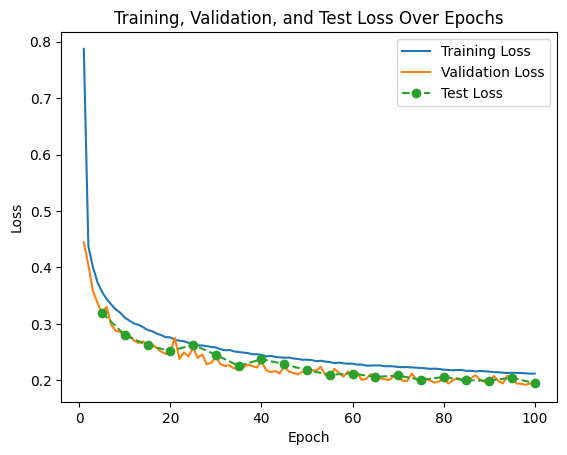

In [9]:
# Plotting
test_interval = 5
epochs_train = range(1, 101)  # Adjust the range based on the actual number of epochs you used
epochs_val = range(1, 101)  # Adjust the range based on the actual number of epochs you used
plt.plot(epochs_train, train_losses, label='Training Loss')
plt.plot(epochs_val, val_losses, label='Validation Loss')
plt.plot(range(test_interval, 101, test_interval), saved_test_losses, label='Test Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.legend()
plt.savefig("loss.png")
plt.show()

In [10]:
from google.colab import files
files.download('losses_dict.pkl')
files.download('best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>